In [1]:
# Tải các thư viện cần thiết
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Các thư viện Scikit-learn (sklearn)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder # <-- QUAN TRỌNG cho bài này
from sklearn.neighbors import KNeighborsClassifier # <-- Sẽ dùng mô hình KNN
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Tải Dữ liệu ---
file_path = 'car.data'

# Cung cấp tên cột (dựa theo mô tả bộ dữ liệu)
column_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

df = pd.read_csv(file_path, header=None, names=column_names)

print("Tải dữ liệu thành công với các tên cột:")
print(df.head()) # In 5 dòng đầu

Tải dữ liệu thành công với các tên cột:
  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc


In [3]:
print("--- Yêu cầu 1: Biểu diễn dữ liệu ---")

# Xem thông tin các cột
print("\nThông tin các cột:")
print(df.info())

--- Yêu cầu 1: Biểu diễn dữ liệu ---

Thông tin các cột:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB
None


In [5]:
# Xem các giá trị duy nhất trong mỗi cột đặc trưng
print("\nCác giá trị duy nhất (features):")
for col in column_names[:-1]: # Lặp qua các cột trừ cột 'class'
    print(f"- Cột '{col}': {df[col].unique()}")


Các giá trị duy nhất (features):
- Cột 'buying': ['vhigh' 'high' 'med' 'low']
- Cột 'maint': ['vhigh' 'high' 'med' 'low']
- Cột 'doors': ['2' '3' '4' '5more']
- Cột 'persons': ['2' '4' 'more']
- Cột 'lug_boot': ['small' 'med' 'big']
- Cột 'safety': ['low' 'med' 'high']


In [7]:
# --- Biểu diễn bằng Matplotlib ---
# Đếm số lượng của cột mục tiêu 'class'
class_counts = df['class'].value_counts()
print(f"\nPhân bổ của cột 'class' (mục tiêu):\n{class_counts}")


Phân bổ của cột 'class' (mục tiêu):
class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


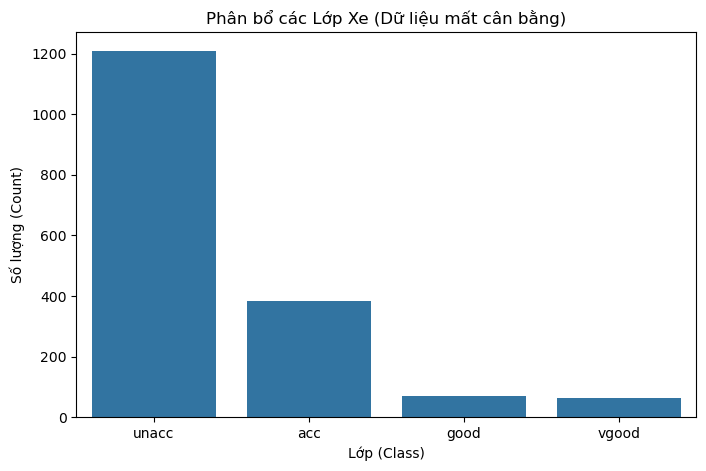

In [9]:
# Vẽ biểu đồ cột
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)

plt.title('Phân bổ các Lớp Xe (Dữ liệu mất cân bằng)')
plt.xlabel('Lớp (Class)')
plt.ylabel('Số lượng (Count)')
plt.show()

In [11]:
print("--- Tiền xử lý: Chuyển đổi Chữ thành Số ---")

# 1. Tách X (đặc trưng) và y (mục tiêu)
X = df.drop('class', axis=1)
y = df['class']

--- Tiền xử lý: Chuyển đổi Chữ thành Số ---


In [15]:
# 2. Mã hóa X (Đặc trưng)
# Định nghĩa thứ tự cho các cột
# Rất quan trọng để mô hình hiểu 'low' là 0 và 'vhigh' là 3
buying_cats = ['low', 'med', 'high', 'vhigh']
maint_cats = ['low', 'med', 'high', 'vhigh']
doors_cats = ['2', '3', '4', '5more']
persons_cats = ['2', '4', 'more']
lug_boot_cats = ['small', 'med', 'big']
safety_cats = ['low', 'med', 'high']
# Khởi tạo encoder
feature_encoder = OrdinalEncoder(categories=[
    buying_cats, maint_cats, doors_cats, persons_cats, lug_boot_cats, safety_cats
])

# Fit và transform X
X_processed = feature_encoder.fit_transform(X)

print("Đã mã hóa X (đặc trưng):")
print(X_processed[:5]) # In 5 dòng đầu đã mã hóa

Đã mã hóa X (đặc trưng):
[[3. 3. 0. 0. 0. 0.]
 [3. 3. 0. 0. 0. 1.]
 [3. 3. 0. 0. 0. 2.]
 [3. 3. 0. 0. 1. 0.]
 [3. 3. 0. 0. 1. 1.]]


In [17]:
# 3. Mã hóa y (Mục tiêu)
target_encoder = LabelEncoder()
y_processed = target_encoder.fit_transform(y)

print("\nĐã mã hóa y (mục tiêu):")
print(y_processed[:5]) # In 5 dòng đầu đã mã hóa
print(f"Các lớp mục tiêu: {target_encoder.classes_}") # Xem mapping: 'acc'->0, 'good'->1...


Đã mã hóa y (mục tiêu):
[2 2 2 2 2]
Các lớp mục tiêu: ['acc' 'good' 'unacc' 'vgood']


In [19]:
print("--- Yêu cầu 2 & 3: Huấn luyện và Đánh giá (Mô hình KNN cơ sở) ---")

# --- Chia dữ liệu ---
# QUAN TRỌNG: Dùng 'stratify=y_processed'
# Để đảm bảo các lớp hiếm như 'good' và 'vgood' được chia đều
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y_processed)

print(f"Tập huấn luyện có {len(X_train)} mẫu.")
print(f"Tập kiểm thử có {len(X_test)} mẫu.")

--- Yêu cầu 2 & 3: Huấn luyện và Đánh giá (Mô hình KNN cơ sở) ---
Tập huấn luyện có 1382 mẫu.
Tập kiểm thử có 346 mẫu.


In [21]:
# --- Yêu cầu 2: Huấn luyện mô hình ---
# Chọn K=5 làm giá trị cơ sở
model_knn_baseline = KNeighborsClassifier(n_neighbors=5)
model_knn_baseline.fit(X_train, y_train)

print("\nĐã huấn luyện xong mô hình KNN (K=5).")


Đã huấn luyện xong mô hình KNN (K=5).



--- Báo cáo Phân loại (Mô hình KNN K=5) ---
              precision    recall  f1-score   support

         acc       0.91      0.90      0.90        77
        good       0.81      0.93      0.87        14
       unacc       0.98      0.99      0.98       242
       vgood       1.00      0.62      0.76        13

    accuracy                           0.95       346
   macro avg       0.92      0.86      0.88       346
weighted avg       0.95      0.95      0.95       346

--- Ma trận Nhầm lẫn (Mô hình KNN K=5) ---


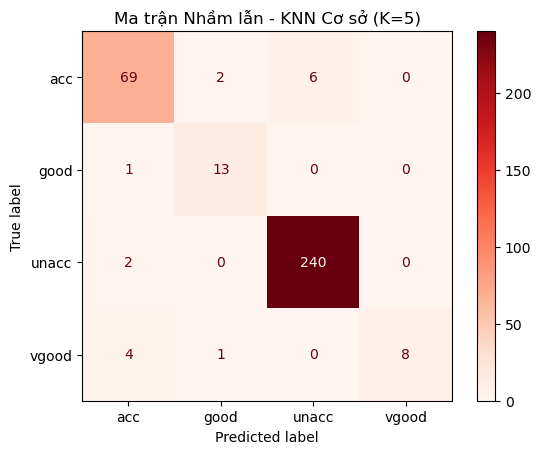

In [23]:
# --- Yêu cầu 3: Đánh giá mô hình ---
y_pred_baseline = model_knn_baseline.predict(X_test)

# 3.1. Dùng Classification Report [cite: 911-913]
print("\n--- Báo cáo Phân loại (Mô hình KNN K=5) ---")
# Lấy tên lớp gốc từ encoder
target_names = target_encoder.classes_ 
print(classification_report(y_test, y_pred_baseline, target_names=target_names))

# 3.2. Dùng Confusion Matrix [cite: 841-846]
print("--- Ma trận Nhầm lẫn (Mô hình KNN K=5) ---")
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=target_names)
disp.plot(cmap="Reds")
plt.title("Ma trận Nhầm lẫn - KNN Cơ sở (K=5)")
plt.show()

--- Yêu cầu 4: Tinh chỉnh Mô hình (Grid Search) ---
Bắt đầu Grid Search để tìm K (n_neighbors) tốt nhất...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Grid Search hoàn tất!
Các tham số tốt nhất tìm được: {'n_neighbors': 5}
Điểm f1-macro tốt nhất trên tập huấn luyện: 0.8331

--- Báo cáo Phân loại (Mô hình TỐT NHẤT sau Tinh chỉnh) ---
              precision    recall  f1-score   support

         acc       0.91      0.90      0.90        77
        good       0.81      0.93      0.87        14
       unacc       0.98      0.99      0.98       242
       vgood       1.00      0.62      0.76        13

    accuracy                           0.95       346
   macro avg       0.92      0.86      0.88       346
weighted avg       0.95      0.95      0.95       346



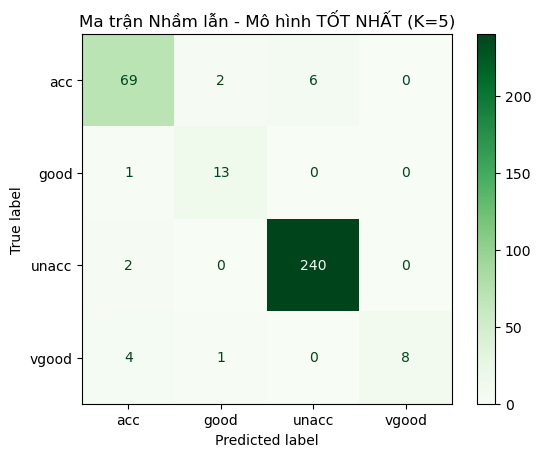

In [25]:
print("--- Yêu cầu 4: Tinh chỉnh Mô hình (Grid Search) ---")

# 1. Định nghĩa không gian tham số (param_grid)
# Chúng ta sẽ thử các giá trị K (n_neighbors) từ 1 đến 11 (chỉ số lẻ)
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11]
}

# 2. Khởi tạo GridSearchCV
# cv=5 (5-fold cross-validation)
# scoring='f1_macro' (chỉ số chúng ta muốn tối ưu)
grid_search = GridSearchCV(KNeighborsClassifier(), # Mô hình gốc
                           param_grid, 
                           cv=5, 
                           scoring='f1_macro', 
                           verbose=1) # verbose=1 để in ra quá trình

print("Bắt đầu Grid Search để tìm K (n_neighbors) tốt nhất...")
# Chạy Grid Search trên TẬP HUẤN LUYỆN
grid_search.fit(X_train, y_train)

# 3. In ra kết quả tốt nhất
print("\nGrid Search hoàn tất!")
print(f"Các tham số tốt nhất tìm được: {grid_search.best_params_}")
print(f"Điểm f1-macro tốt nhất trên tập huấn luyện: {grid_search.best_score_:.4f}")

# 4. Lấy mô hình tốt nhất đã được huấn luyện
best_model = grid_search.best_estimator_

# --- Đánh giá lại mô hình TỐT NHẤT trên tập TEST ---
y_pred_best = best_model.predict(X_test)

print("\n--- Báo cáo Phân loại (Mô hình TỐT NHẤT sau Tinh chỉnh) ---")
print(classification_report(y_test, y_pred_best, target_names=target_names))

# Vẽ ma trận nhầm lẫn
cm_best = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=target_names)
disp.plot(cmap="Greens")
plt.title(f"Ma trận Nhầm lẫn - Mô hình TỐT NHẤT (K={best_model.n_neighbors})")
plt.show()